# Прогнозирование минимального остатка

Г.Бут (gbooth@yandex.ru),  2021/12/28



## Общая постановка задачи
Розничный банк (обслуживающий физических лиц) имеет специальный тип продукта - текущие розничные счета до востребования. В отличие от депозита, который размещается на определенный срок, текущий счет допускает снятие всей суммы средств со счета в любой момент. Однако на практике малореально, что все клиенты разом закроют текущие счета в банке, если только у них нет сомнений в долгосрочной работе банка. Всегда кто-то снимает деньги, а кто-то пополняет счет - соответственно у всей суммы счетов до востребования есть некоторый минимальный уровень, ниже которого не опустится суммарный обьем остатков. В задаче необходимо научиться прогнозировать такой минимальный уровень остатков - уровень стабильных средств.

Модель будет предсказывать некую величину за период длительностью один или несколько месяцев. На практике возможны два варианта ошибок - модель будет занижать объем стабильных средств и в реальности стабильный остаток будет больше, чем предсказано моделью.   Другой вариант - модель будет завышать объем стабильных средств и возможна ситуация пробития предсказания - когда фактическая сумма неснижаемых средств будет меньше предсказанной.  Оба варианта чреваты потерями для банка - в одном случае он недополучит прибыль от размещения свободных средств, в другом будет вынужден занимать средства на рынке для латания дыры в текущей ликвидности.  По условиям задачи необходимо одновременно минимизировать обе эти величины.

Модель должна быть построена в формате функции, например:
model_forecast(2019-02-01, ‘1М’, История_до_2019-02-01) = стабильная часть на 1М
Возможные горизонты прогнозирования: 1М, 2М, 3М, 4М, 5М, 6М, 7М, 8М, 9М, 10М, 11М, 12М

Можно использовать любые модели - как вариант построить квантильную регрессию для прогнозирования ряда.

 ## Краткое резюме
 Предложения композитная модель для предсказания минимального неподвижного остатка на текущих счетах. Основу составляет линейный прогноз с добавленным сезонным трендом. На основе ошибки предсказания модели на учебных данных анализируется распределение и оценивается квантиль уровня 0.01.  Итоговое значение предсказания определяется как минимум разности прогнозированного значения с учетом отклонения квантиля 0.01 за требуемый период.

Модель ошибается в основном в плюс - недооценивает уровень минимального остатка на счетах до востребования. Урровень ошибки MPE составляет от 3% для краткосрочных прогнозов до 3х месяцев, до 6..6.5 % для среднесрочных прогнозов 6 и 9 месяцев.

 ## Импорт библиотек

Часть функций, разработанных мною в ходе решения задачи вынесена в библиотеку P10_Lib.

In [369]:
import numpy as np
import pandas as pd

from warnings import simplefilter
import time
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from importlib import reload
from sklearn.linear_model import QuantileRegressor

import P10_Lib as pr_lib

simplefilter("ignore")  # ignore warnings to clean up output cells

In [309]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc( "axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10 )
plot_params = dict( color="0.75", style="-", markeredgecolor="0.25", markerfacecolor="0.25", legend=False)
%config InlineBackend.figure_format = 'retina'


## Знакомство с данными

In [310]:
df = pd.read_csv('./input/data.csv',sep=';', parse_dates=['REPORTDATE'], dayfirst=True)
df.head(5)

,REPORTDATE,VALUE
0,2013-12-30,3457625638
1,2013-12-31,3417092149
2,2014-01-01,3417092149
3,2014-01-02,3417092149
4,2014-01-03,3417092149


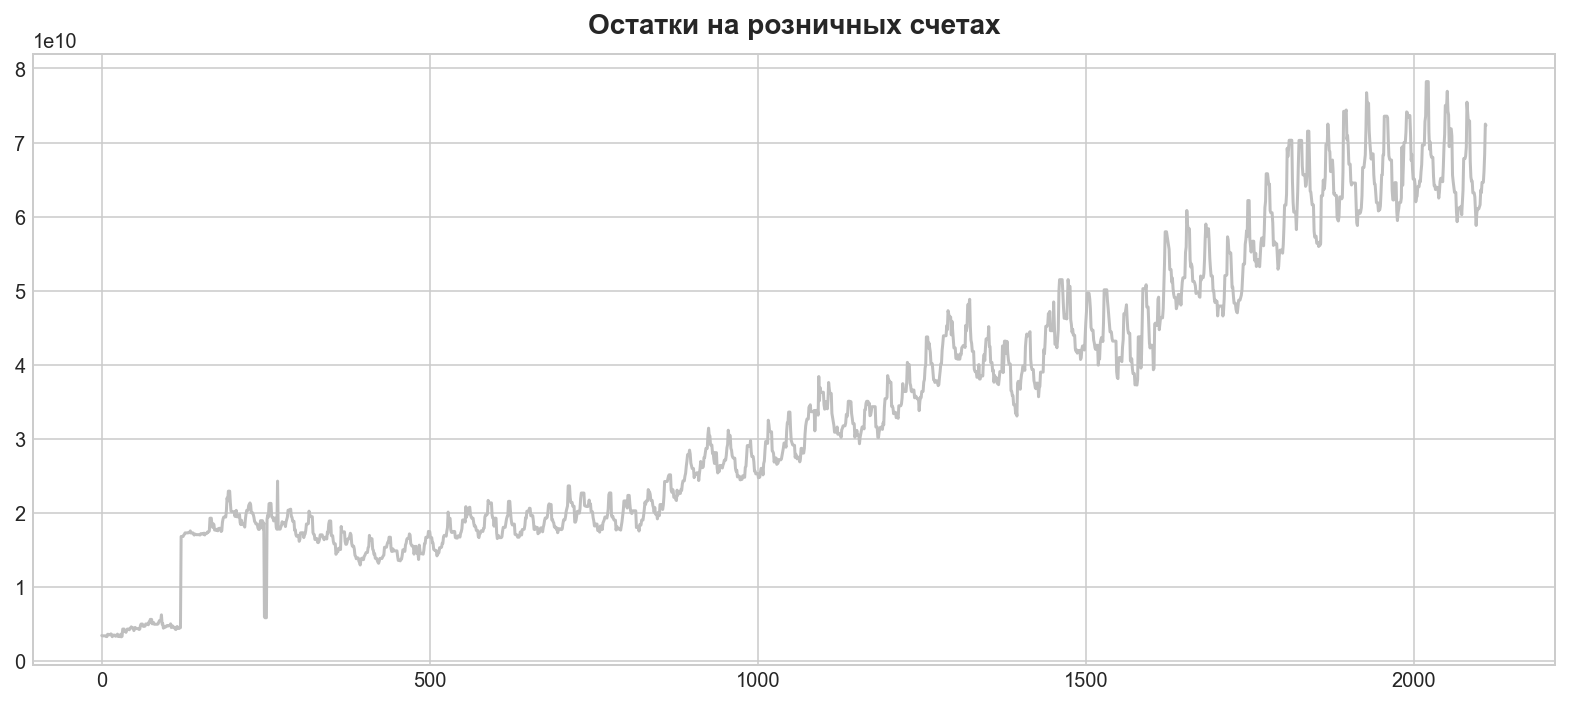

In [311]:
ax=df.VALUE.plot(**plot_params)
ax.set_title('Остатки на розничных счетах');

Данные предоставлены без ожидавшихся пропусков на выходные и праздничные дни. Можно предположить что они прошли подготовку перед предоставлением.
Визуальный анализ данных показывает наличие трех сильных выбросов ликвидности:
  - скачкообразный прирост ликвидности на 120 день в сумме порядка 11-12 млрд,
  - провал ликвидности на 248-251 день
  - скачок ликвидности на 268 день.

Это могут быть выбросы или (вероятнее) ручные коректировки даннных предоставляемых публично данных. Такие выбросы будут вносить существенную ошибку в обучение модели. Можно откорректировать эти данные вручную. Однако же график показывает что в районе 400 дня наблюдений возможно произошел "разворот тренда". Для обучения модели представляют интерес последние данные "после разворота".  Поэтому вместо корректировки данных вручную отброшу первые 270 наблюдений из набора.

In [312]:
df = df.drop(df.index[0:269])

Для прогнозирования сформирую детерминированные условия - номер наблюдения по порядку и некую константу для использования в моделях.
Данные в модели имеют денежное выражение. Денежные средства лучше всего анализировать в логарифмическом представлении - чтобы инфляционные эффекты превратились из мультипликативных в аддитивные.  Возьму логарифм остатков и посморю на логарифм остатков.

In [313]:
df = df.set_index('REPORTDATE')
df['time'] = np.arange(len(df.index))
df['const'] = 1
df['log_balance'] = np.log(df.VALUE)
df.head()

,VALUE,time,const,log_balance
REPORTDATE,,,,
2014-09-25,17841644058,0,1,23.604801
2014-09-26,17824637391,1,1,23.603847
2014-09-27,17824637391,2,1,23.603847
2014-09-28,17824637391,3,1,23.603847
2014-09-29,18128532199,4,1,23.620753


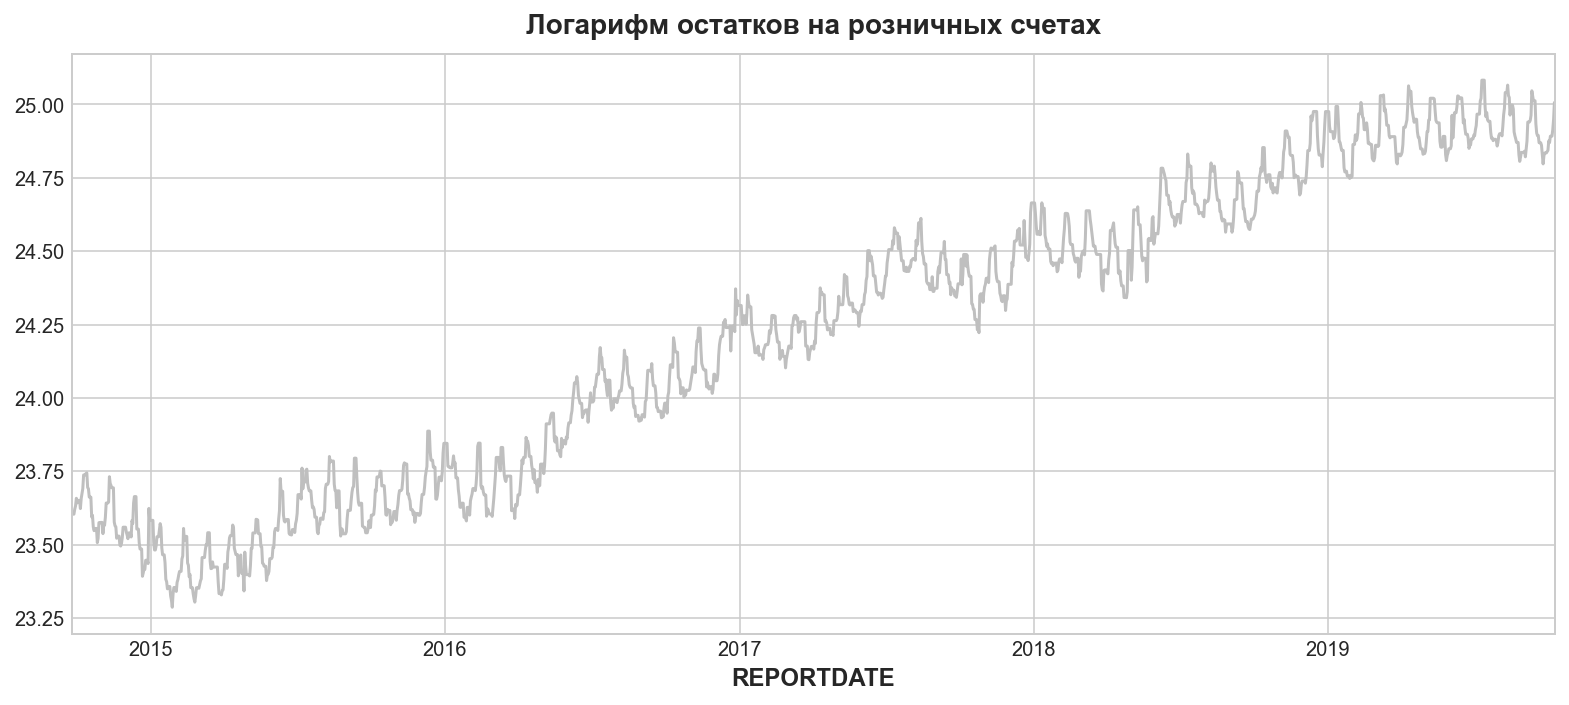

In [314]:
ax=df.log_balance.plot(**plot_params)
ax.set_title('Логарифм остатков на розничных счетах');

В данных можно предположить еще один перелом тренда, произошедший в начале 2019 года. Этот год не похож на предыдущие. Можно ожидать, что модель будет ошибаться при предсказаниях в 2019 году.

Стратегия проверки результатов моделирования будет основана на принципе плавающего окна. Это значит, что для модель будет разработана и отлажена на данных фиксированного разделения на обучающую часть в составе 2015-2016 годов и тестовую часть 2017 года. При этом будет разработана модель для предсказания на 1 месяц. Затем модель будет превращена в функцию и оттестирована со скользящим окном истории в пределах 2015-2017 годов, а затем и с более длинным периодом предстказания.


In [315]:
train = df.loc['2015-01-01':'2016-12-31',:]
test = df.loc['2017-01-01':'2017-12-31',:]
train_test = df.loc['2015-01-01':'2017-12-31',:]

Нормализую значения временного признака. Пусть моменту начала учебного периода будет соответствовать -1, концу учебного периода 0, время в тестовый период будет положительным.

In [316]:
max_time = train.time.max()
min_time = train.time.min()
span = max_time-min_time
train.time = (train.time - max_time)/span
test.time = (test.time-max_time)/span

##  Подбор модели

Попробую сделать пару наивных моделей прогнозирования на основе линейной и квантильной регрессии. Обучим их на данных за учебный период а график построим за весь период наблюдения.

In [317]:
X_tr = train.loc[:, ['time', 'const']]
y_tr = train.loc[:, 'log_balance']
X_ts = test.loc[:, ['time', 'const']]
y_ts = test.loc[:, 'log_balance']

In [318]:
model = LinearRegression(fit_intercept=False)
model.fit(X_tr, y_tr)
y_pr = pd.Series(model.predict(X_ts), index=X_ts.index)

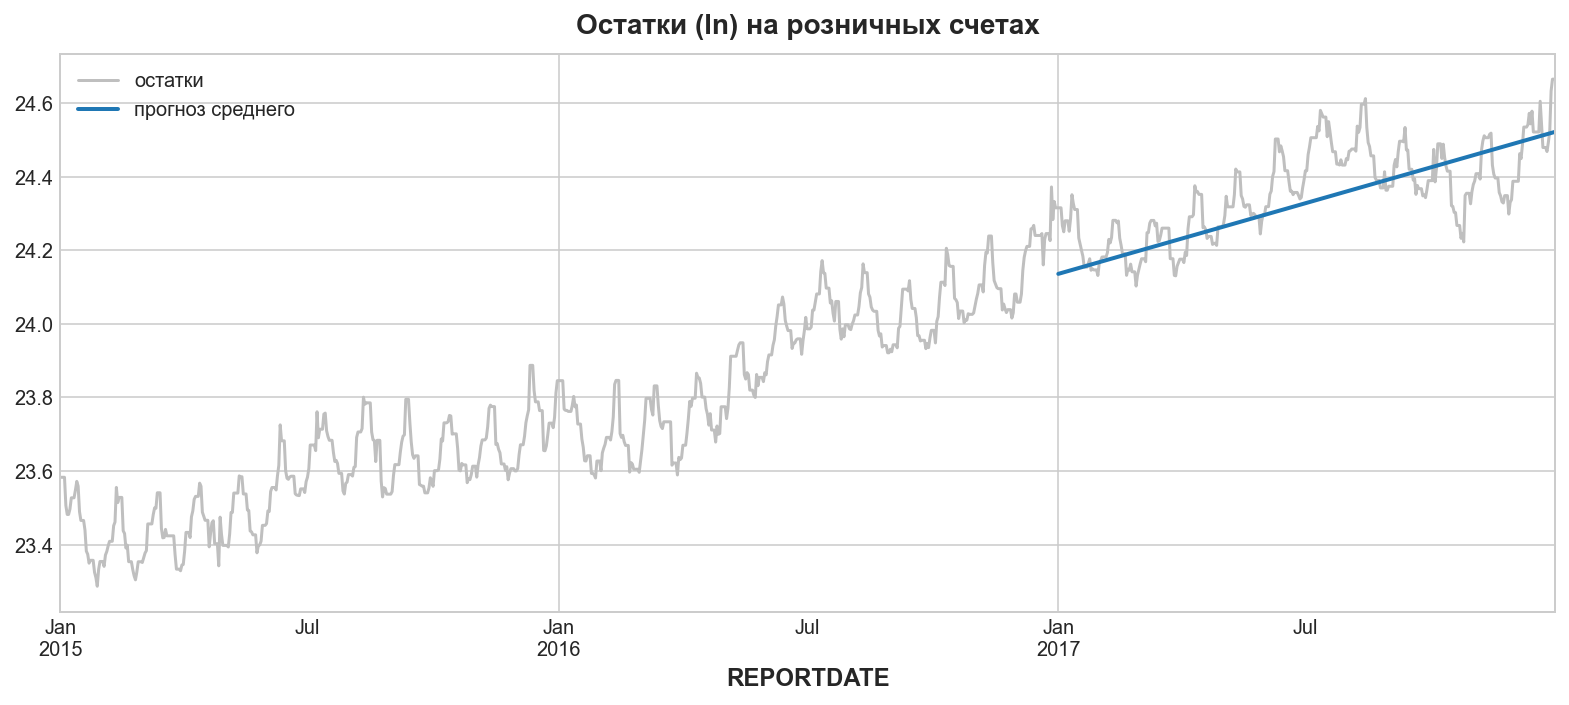

In [319]:
ax = train_test.log_balance.plot(**plot_params, label='остатки')
ax = y_pr.plot(ax=ax, linewidth=2, label='прогноз среднего' )
ax.set_title('Остатки (ln) на розничных счетах')
_ = ax.legend();

Линейная модель предсказывает центральное значение, довольно быстра и устойчива в работе. Посмотрю еще на модель квантильной регрессии.

In [320]:
was = time.perf_counter()
quantiles = [0.05,0.5,0.95]
predictions = {}
for q in quantiles:
    qr = QuantileRegressor(quantile=q, alpha=0.005, fit_intercept=False)
    qr.fit(X_tr,y_tr)
    predictions[q] = pd.Series(qr.predict(X_ts), index=X_ts.index)
print('Done in {:.4f} sec'.format(time.perf_counter() - was))
# model = LinearRegression()
# model.fit(X, y)
# Xc = df.loc[:, ['time']]
# yc = pd.Series(model.predict(Xc), index=Xc.index)

Done in 28.7305 sec


Модель оказалась сильно зависима от коэффициента регуляризации alpha. При слишком низких значениях на предоставленных данных она "сваливается в штопор".  Вероятно лучше избегать ее для готового решения.

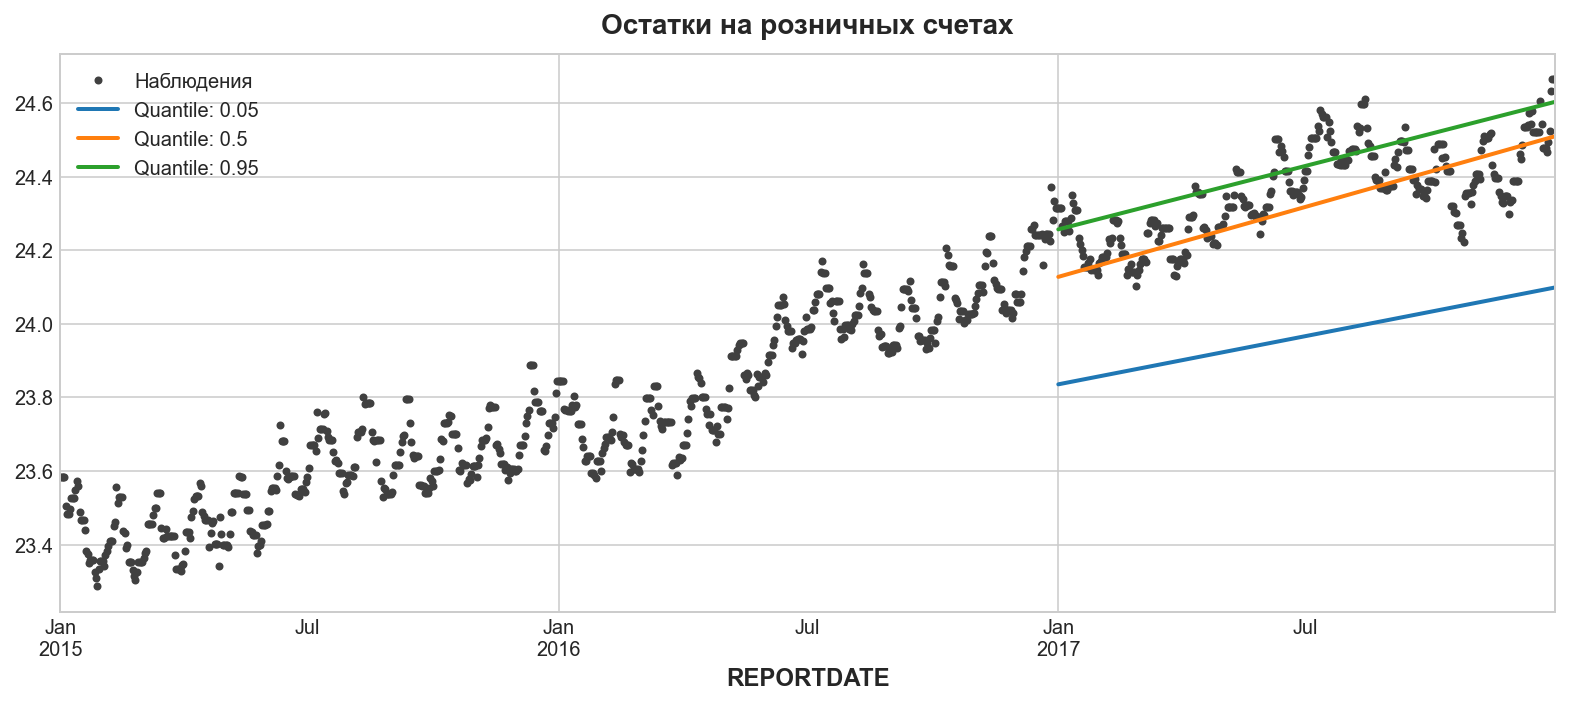

In [321]:
ax = train_test.log_balance.plot(color='0.25', style='.', label="Наблюдения", title='Остатки на розничных счетах')
for q, yp in predictions.items():
    ax = yp.plot( ax=ax, label=f"Quantile: {q}", linewidth=2)
_ = ax.legend()

Чисто внешне модель предсказания на основе линейной регрессии нравится больше. Квантильная регрессия подогналась под старые наблюдения и не очень хорошо прогнозирует текущий момент. Величина минимального остатка при прогнозировании на год оказывается слишком низкой.


Возникает идея объединить достоинства обоих подходов.  Идея состоит в том, чтобы на основе линейной регрессии обучить модель. Затем посчитать остаточную ошибку моделирования на той же самой учебной выборке - на полном интервале или за несколько последних месяцев и определить, например ее квантиль 0.01. Затем необходимо сдвинуть прогноз вниз на величину отклонения квантиля.

Базовое допущение подхода несколько отличается от принятого в классическом финансовом риск-менеджменте. Я предполагаю, что случайный процесс колеблется вокруг центрального значения и волатильность этих колебаний стабильная и не зависит от времени прогнозирования.

In [322]:
model_error = y_tr - pd.Series(model.predict(X_tr), index=X_tr.index)

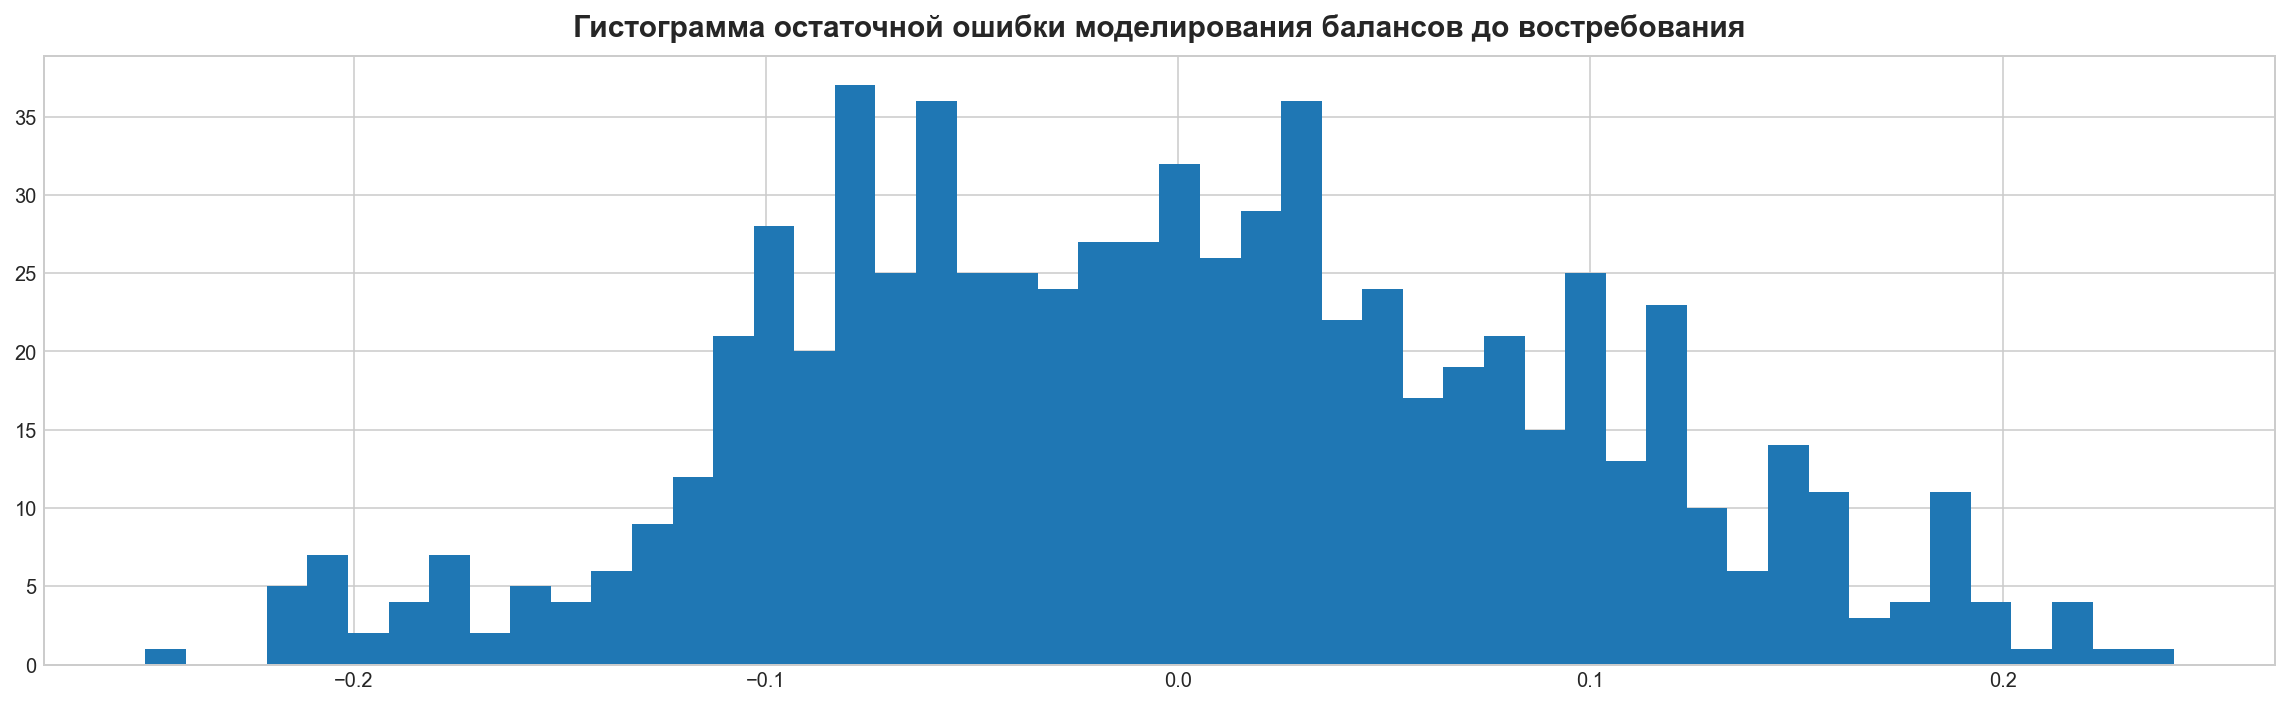

In [323]:
plt.figure(figsize=(16, 5))
plt.hist(model_error, bins=50)
plt.title('Гистограмма остаточной ошибки моделирования балансов до востребования', fontsize =15)
plt.show();

In [324]:
pr_lib.show_quantile_hurdle(model_error)

0.00   -0.250599
0.01   -0.207102
0.05   -0.142817
0.25   -0.067872
0.50   -0.002728
0.75    0.065833
0.95    0.155991
0.99    0.200784
1.00    0.241497
dtype: float64

 Low hurdle: -0.2684 high hurdle: 0.2664


Коридор остаточной ошибки получается довольно компактным. Попробую построить доверительные интервалы для прогноза. В качестве границ доверительного интервала возьму квантили 0.01 и 0.99. В дальнейшем этот гиперпараметр можно будет подобрать.


In [325]:
model_error_quantile = model_error.quantile(q=[0.01,0.5,0.99])
lo_error = y_pr + model_error_quantile[0.01]
hi_error = y_pr + model_error_quantile[0.99]

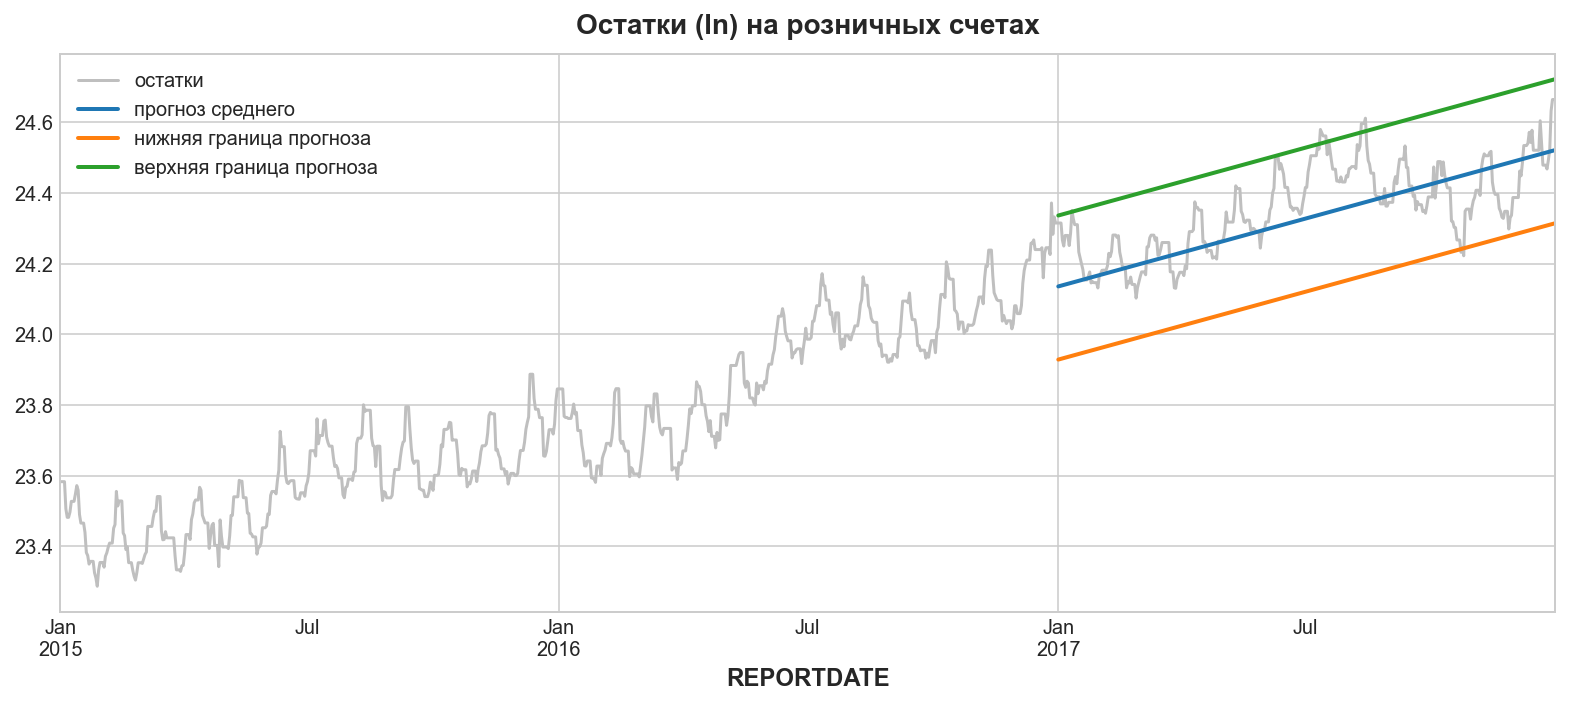

In [326]:
ax = train_test.log_balance.plot(**plot_params, label='остатки')
ax = y_pr.plot(ax=ax, linewidth=2, label='прогноз среднего' )
ax = lo_error.plot(ax=ax, linewidth=2, label='нижняя граница прогноза' )
ax = hi_error.plot(ax=ax, linewidth=2, label='верхняя граница прогноза' )
ax.set_title('Остатки (ln) на розничных счетах')
_ = ax.legend();

##  Учет сезонности.

Линейный прогноз не учитывает сезонные компоненты. Посмотрю на наличие сезонности - на спектр (АЧХ) динамики остатков.

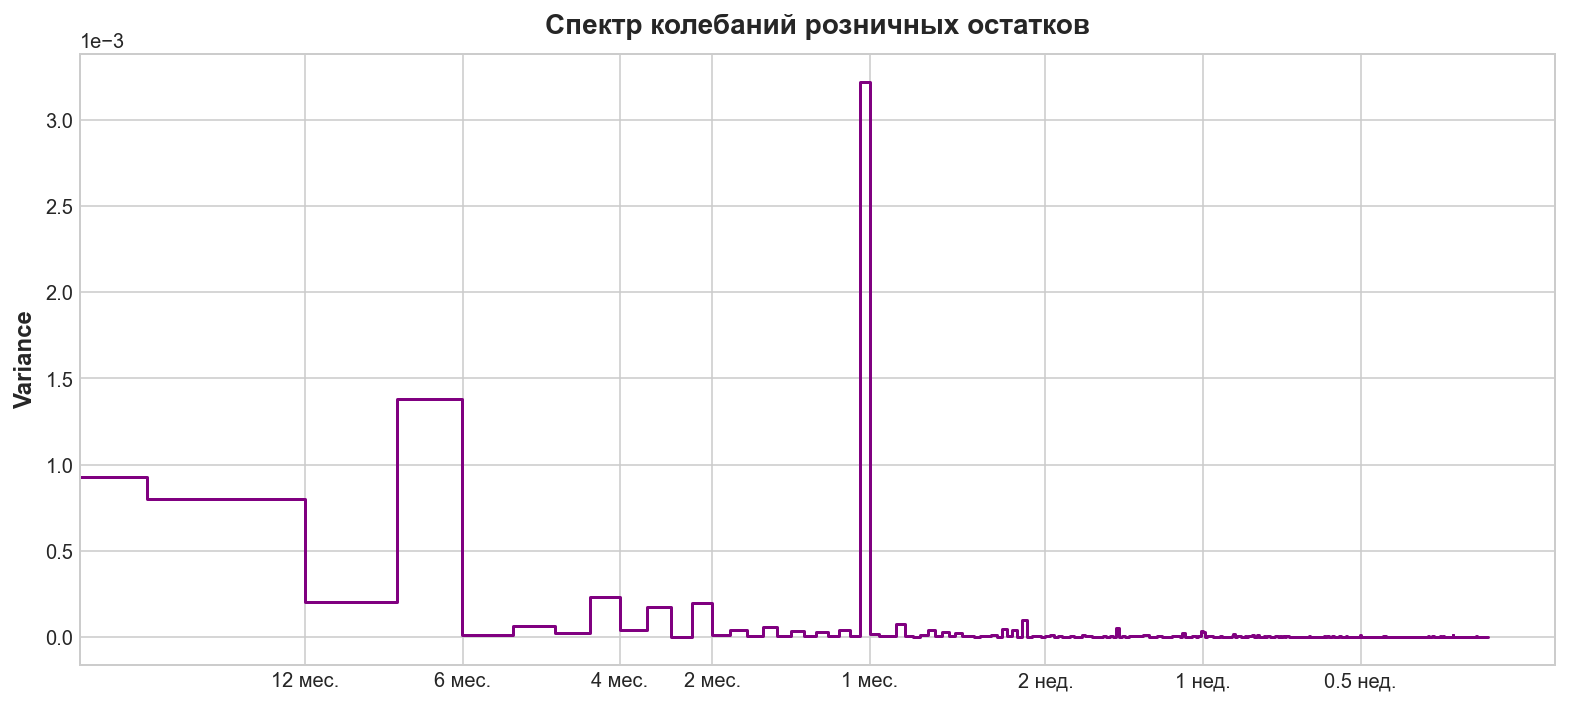

In [327]:
pr_lib.plot_periodogram(train.log_balance,title='Спектр колебаний розничных остатков');

В спектре временных колебаний розничных остатков выделяются сезонные колебания с периодами 1 месяц и 6 месяцев.
Сезонный цикл длительностью 1 мес. сглаживается по условиям задачи.  Поработаю с сезонным циклом 6 месяцев.

In [328]:

train_test['year'] = train_test.index.year
train_test['month'] = train_test.index.month
monthly_average = train_test.groupby(['year', 'month']).log_balance.mean()
train_test['monthly_avg'] = train_test.apply(lambda r: monthly_average[r.year,r.month], axis=1)
train_test.head()

,VALUE,time,const,log_balance,year,month,monthly_avg
REPORTDATE,,,,,,,
2015-01-01,17452425921,98,1,23.582744,2015,1,23.452233
2015-01-02,17452425921,99,1,23.582744,2015,1,23.452233
2015-01-03,17452425921,100,1,23.582744,2015,1,23.452233
2015-01-04,17452425921,101,1,23.582744,2015,1,23.452233
2015-01-05,16162817600,102,1,23.505979,2015,1,23.452233


Закодирую месяц в пределах полугодия и сделаю профиль (периодограмму) сезонной компоненты.

В данном случае я использую разработанный мной подход по представлению сезонности в табличной форме. (https://github.com/Genn007/Time_Series_Forecasting_Issues/blob/main/TargetEncoding_in_TS_Rus.ipynb)  В целом подход оказывается довольно простым.  Модель реализуется аналогично модели Хольта-Винтерса, однако без авторегрессии, а с обучением линейной экстраполяции на большом периоде прошедших данных и предсказанием будущего периода путем простой экстраполяции.  Сезонный компонент, аналогично модели Винтерса, представляет собой некий набор коэффициентов, привязанных к календарю, и участвующих в прогнозировании линейного тренда.



In [329]:
train_test['mon_semiyear'] = train_test.month.apply(lambda m: m if m < 7 else m-6)

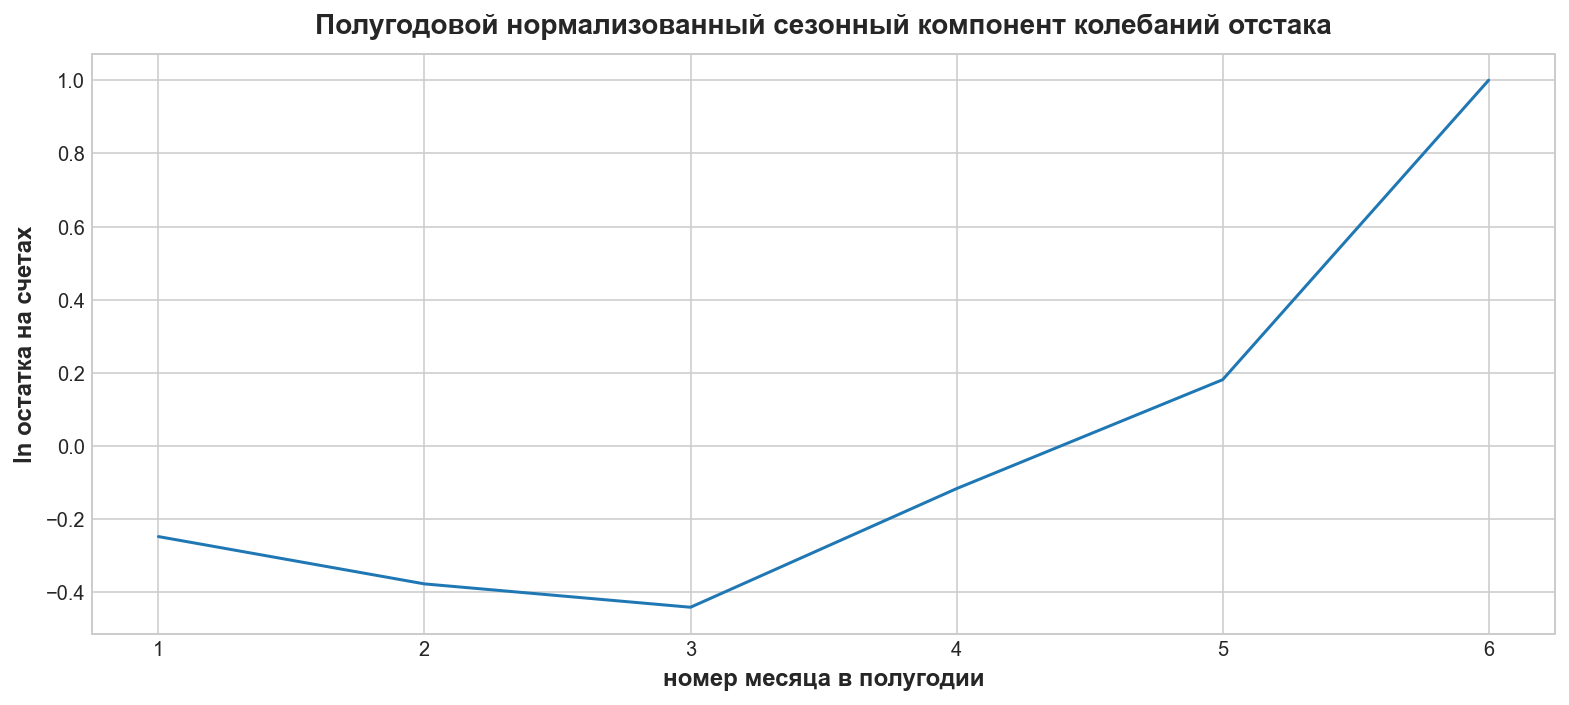

In [330]:
train = train_test.loc['2015-01-01':'2016-12-31',:]
norm_semi_ann_season = pr_lib.estimate_seasonal_trend(train,'log_balance','mon_semiyear',(1,6), normalise=True)
plt.plot(norm_semi_ann_season.keys(), norm_semi_ann_season.values())
plt.xlabel("номер месяца в полугодии")
plt.ylabel('ln остатка на счетах')
plt.title('Полугодовой нормализованный сезонный компонент колебаний отстака');

Посмотрим на моделирование остатков с использованием полугодовой сезонной компоненты.

In [331]:
train_test['annual_season'] = train_test.mon_semiyear.apply(lambda w: norm_semi_ann_season[w])
train = train_test.loc['2015-01-01':'2016-12-31',:]
test = train_test.loc['2017-01-01':'2017-12-31',:]
train.head()

,VALUE,time,const,log_balance,year,month,monthly_avg,mon_semiyear,annual_season
REPORTDATE,,,,,,,,,
2015-01-01,17452425921,98,1,23.582744,2015,1,23.452233,1,-0.247463
2015-01-02,17452425921,99,1,23.582744,2015,1,23.452233,1,-0.247463
2015-01-03,17452425921,100,1,23.582744,2015,1,23.452233,1,-0.247463
2015-01-04,17452425921,101,1,23.582744,2015,1,23.452233,1,-0.247463
2015-01-05,16162817600,102,1,23.505979,2015,1,23.452233,1,-0.247463


In [332]:
X_tr = train.loc[:, ['time', 'const', 'annual_season']]
y_tr = train.loc[:, 'log_balance']
X_ts = test.loc[:, ['time', 'const', 'annual_season']]
y_ts = test.loc[:, 'log_balance']
model = LinearRegression(fit_intercept=False)
model.fit(X_tr, y_tr)
y_pr = pd.Series(model.predict(X_ts), index=X_ts.index)
model_error = y_tr - pd.Series(model.predict(X_tr), index=X_tr.index)
model_error_quantile = model_error.quantile(q=[0.01,0.5,0.99])
lo_error = y_pr + model_error_quantile[0.01]
hi_error = y_pr + model_error_quantile[0.99]

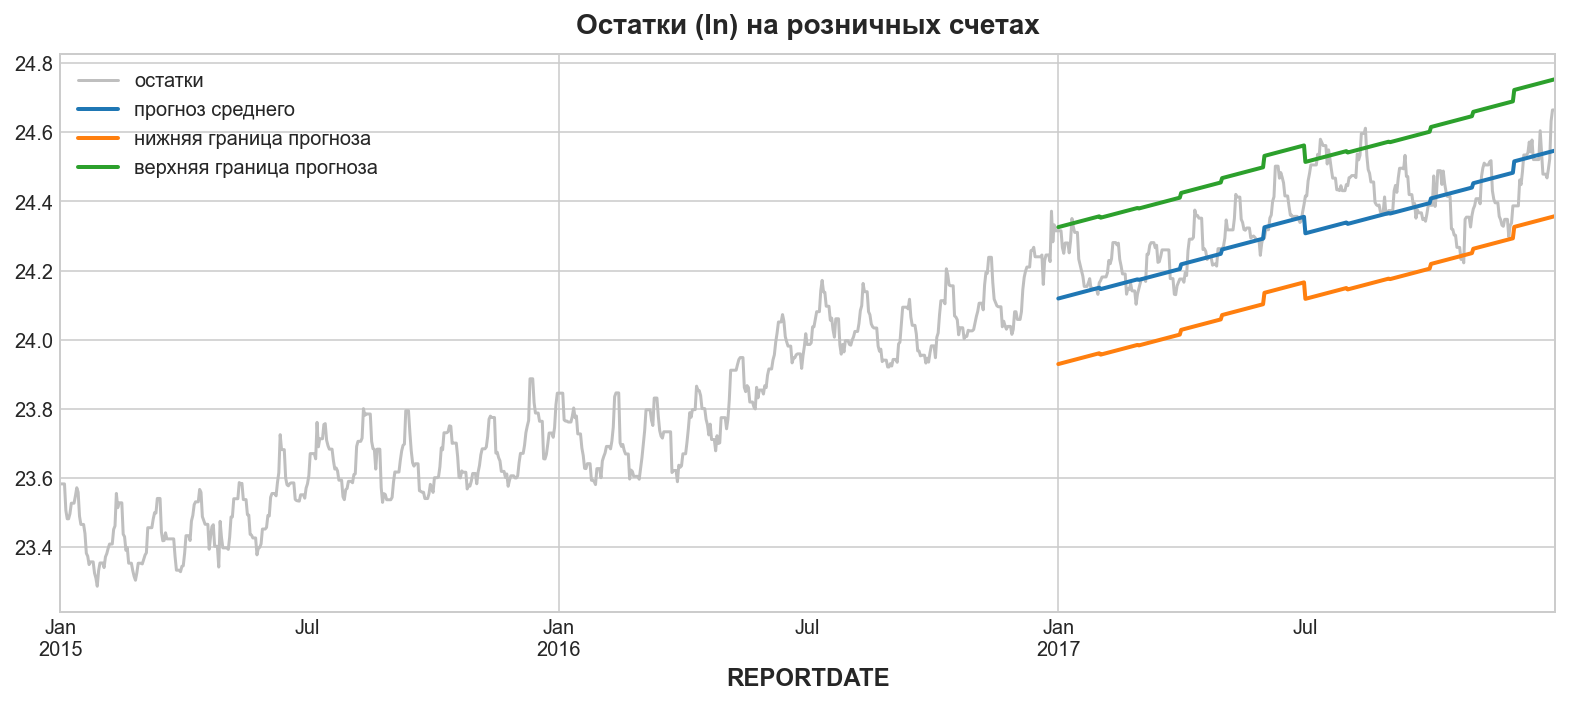

In [333]:
ax = train_test.log_balance.plot(**plot_params, label='остатки')
ax = y_pr.plot(ax=ax, linewidth=2, label='прогноз среднего' )
ax = lo_error.plot(ax=ax, linewidth=2, label='нижняя граница прогноза' )
ax = hi_error.plot(ax=ax, linewidth=2, label='верхняя граница прогноза' )
ax.set_title('Остатки (ln) на розничных счетах')
_ = ax.legend();

График прогнозирование верхней и нижней границы остатков оказывается достаточно привлекательным для решения задачи - для годового прогноза фактическая величина минимальных остатков пробивает прогноз пару раз, а не недооценивает его, как это делает модель квантильной регрессии.

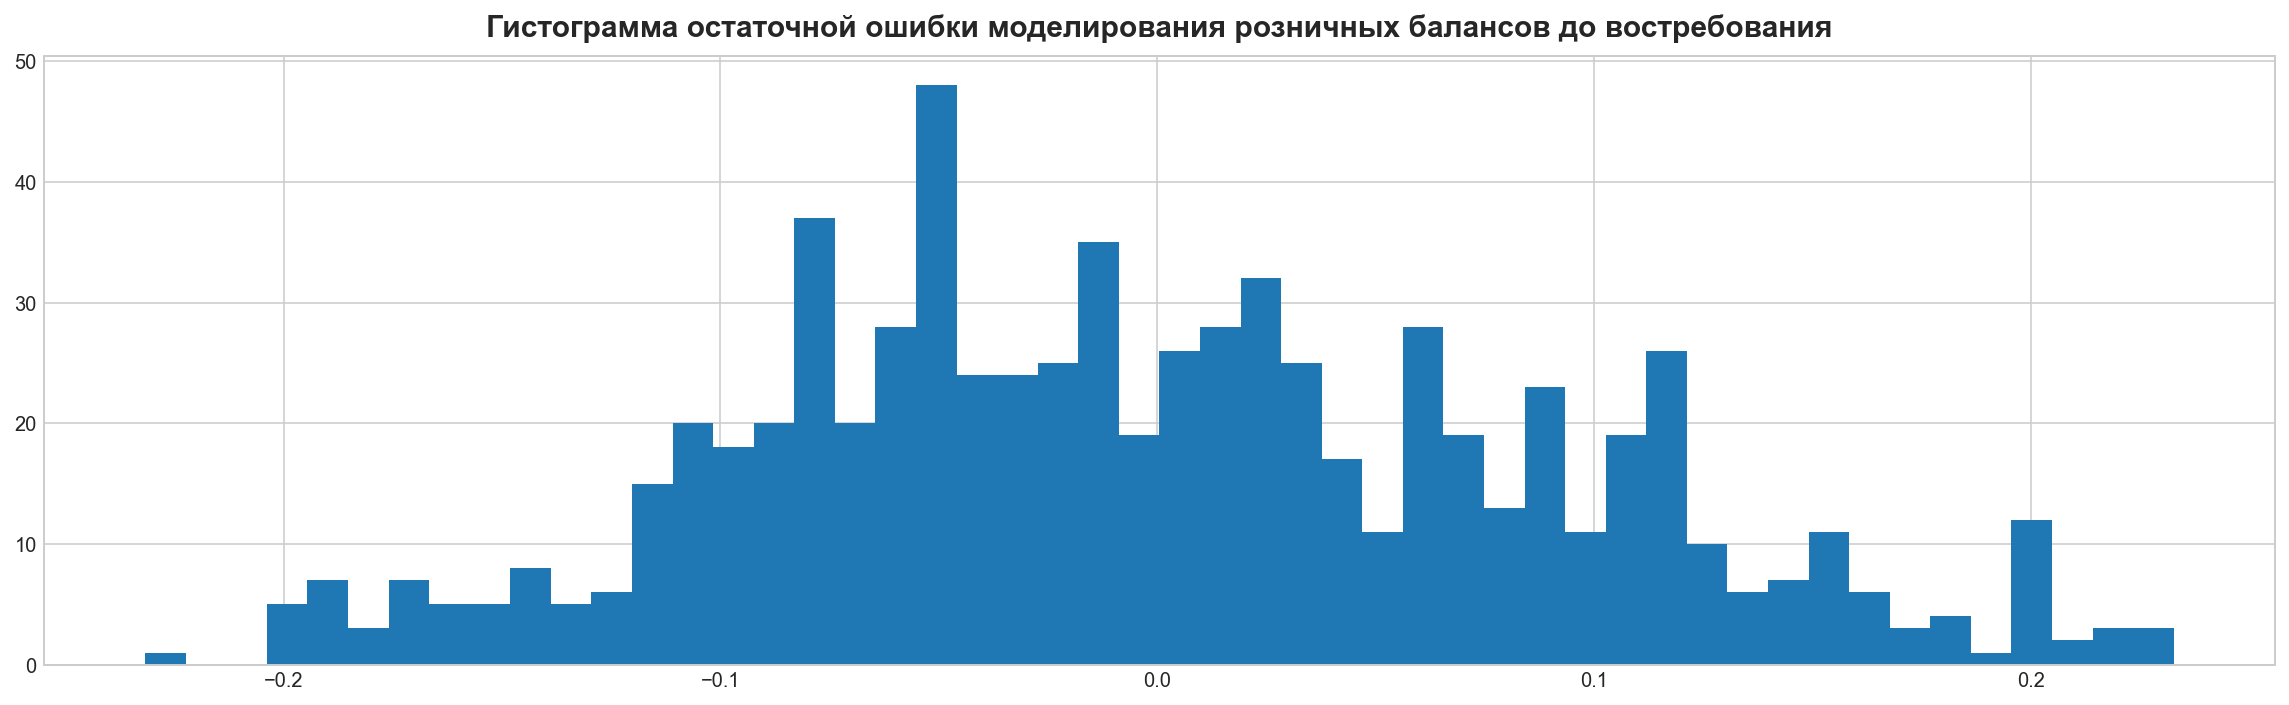

In [334]:
plt.figure(figsize=(16, 5))
plt.hist(model_error, bins=50)
plt.title('Гистограмма остаточной ошибки моделирования розничных балансов до востребования', fontsize =15)
plt.show();

In [335]:
pr_lib.show_quantile_hurdle(model_error)

0.00   -0.231762
0.01   -0.189648
0.05   -0.141020
0.25   -0.064312
0.50   -0.008873
0.75    0.064558
0.95    0.155839
0.99    0.206520
1.00    0.232778
dtype: float64

 Low hurdle: -0.2576 high hurdle: 0.2579


Доверительный интервал сжался примерно на 200 базисных пунктов. Эффект от моделирования сезонного колебания есть, но не значительный. Сделаю отдельную функцию для моделирования среднего значения, нижней и верхней границ остатков для различных временных периодов.

Для обучения линейной модели я использую достаточно длительный период времени с фактором от 3х до 2х к требуемой длительности прогноза - то есть от 3х месяцев для построения месячного прогноза до 24х месяцев для построения 12-ти месячного прогноза.

В ходе работы над вынесенной моделью принято решение, что полугодовой сезонный фактор учитывается только для прогнозных периодов длительностью свыше 3х месяцев. При меньших длительностях используется линейный прогноз.
Возможно, это не лучшее решение - лучше было бы строить сезонный профиль на двухлетних данных, а затем обучать модель на более коротком временном промежутке.

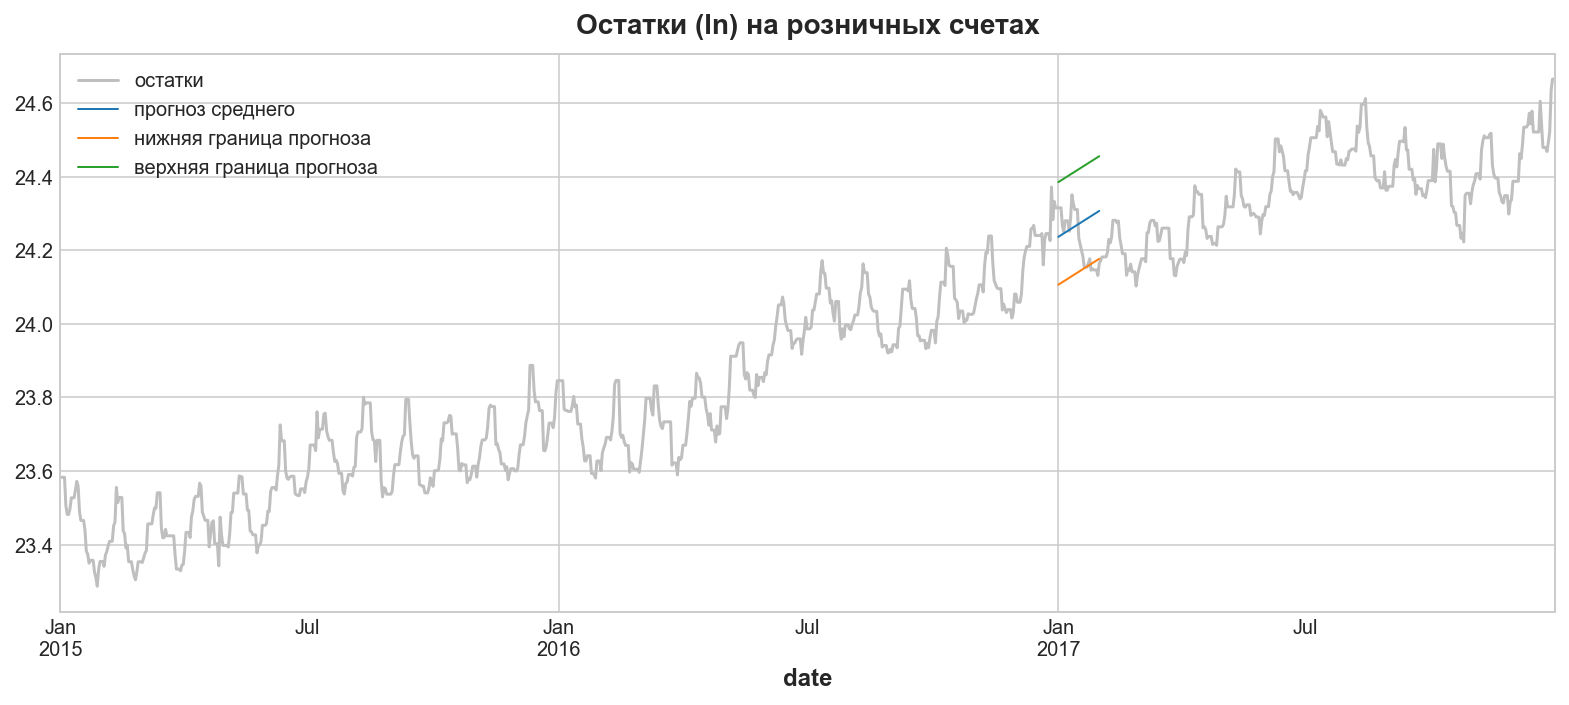

In [336]:
y_pred, lo_pred, hi_pred = pr_lib.predict_timeframe('2017-01-01',train_test, period='1M')
ax = train_test.log_balance.plot(**plot_params, label='остатки')
ax = y_pred.plot(ax=ax, linewidth=1, label='прогноз среднего' )
ax = lo_pred.plot(ax=ax, linewidth=1, label='нижняя граница прогноза' )
ax = hi_pred.plot(ax=ax, linewidth=1, label='верхняя граница прогноза' )
ax.set_title('Остатки (ln) на розничных счетах')
_ = ax.legend();

Посмотрим на прогнозирование средних остатков на розничных счетах.

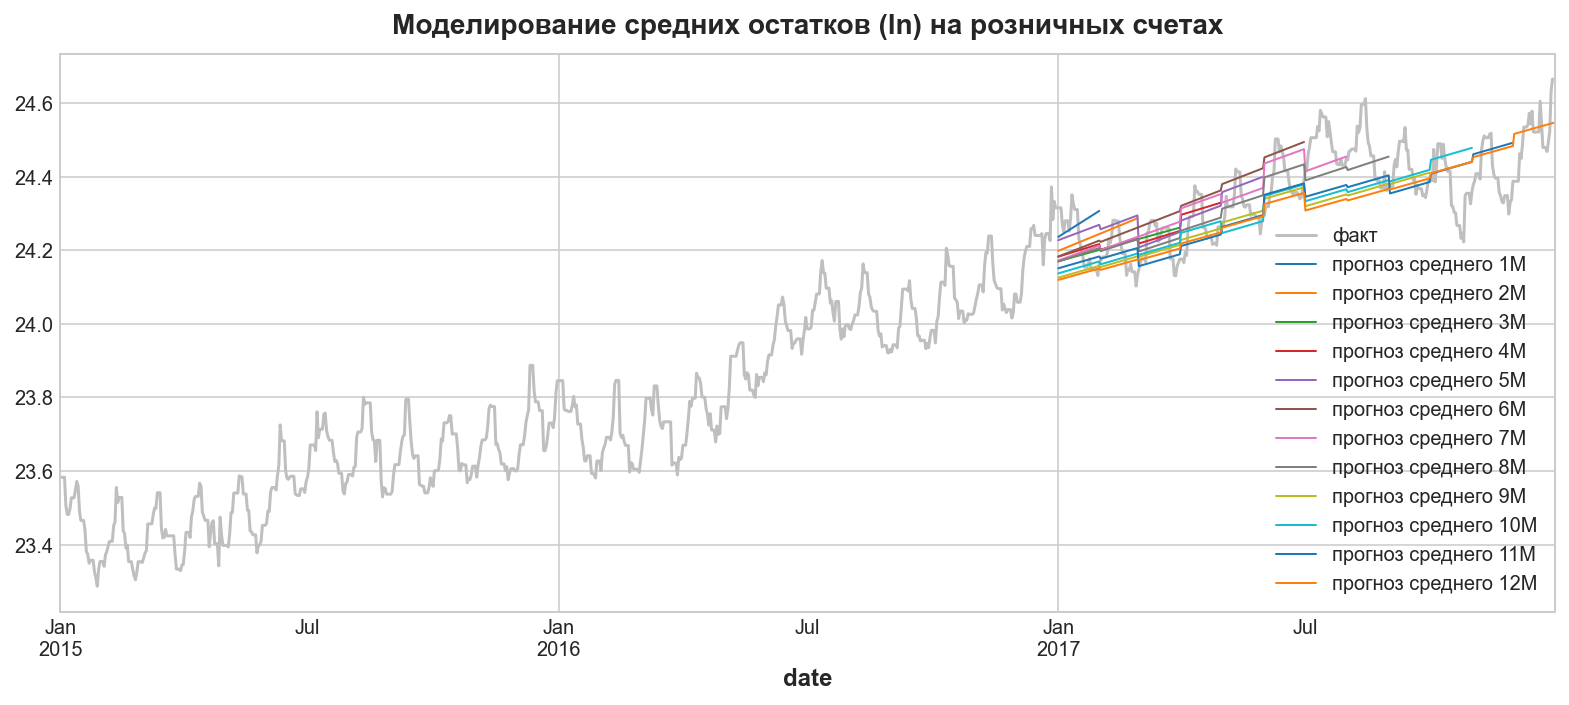

In [337]:
ax = train_test.log_balance.plot(**plot_params, label='факт')
for p in ['1M','2M','3M','4M','5M','6M','7M','8M','9M','10M','11M','12M']:
    y_pred, _, _ = pr_lib.predict_timeframe('2017-01-01',train_test, period=p)
    ax = y_pred.plot(ax=ax, linewidth=1, label='прогноз среднего '+p )
ax.set_title('Моделирование средних остатков (ln) на розничных счетах')
_ = ax.legend();

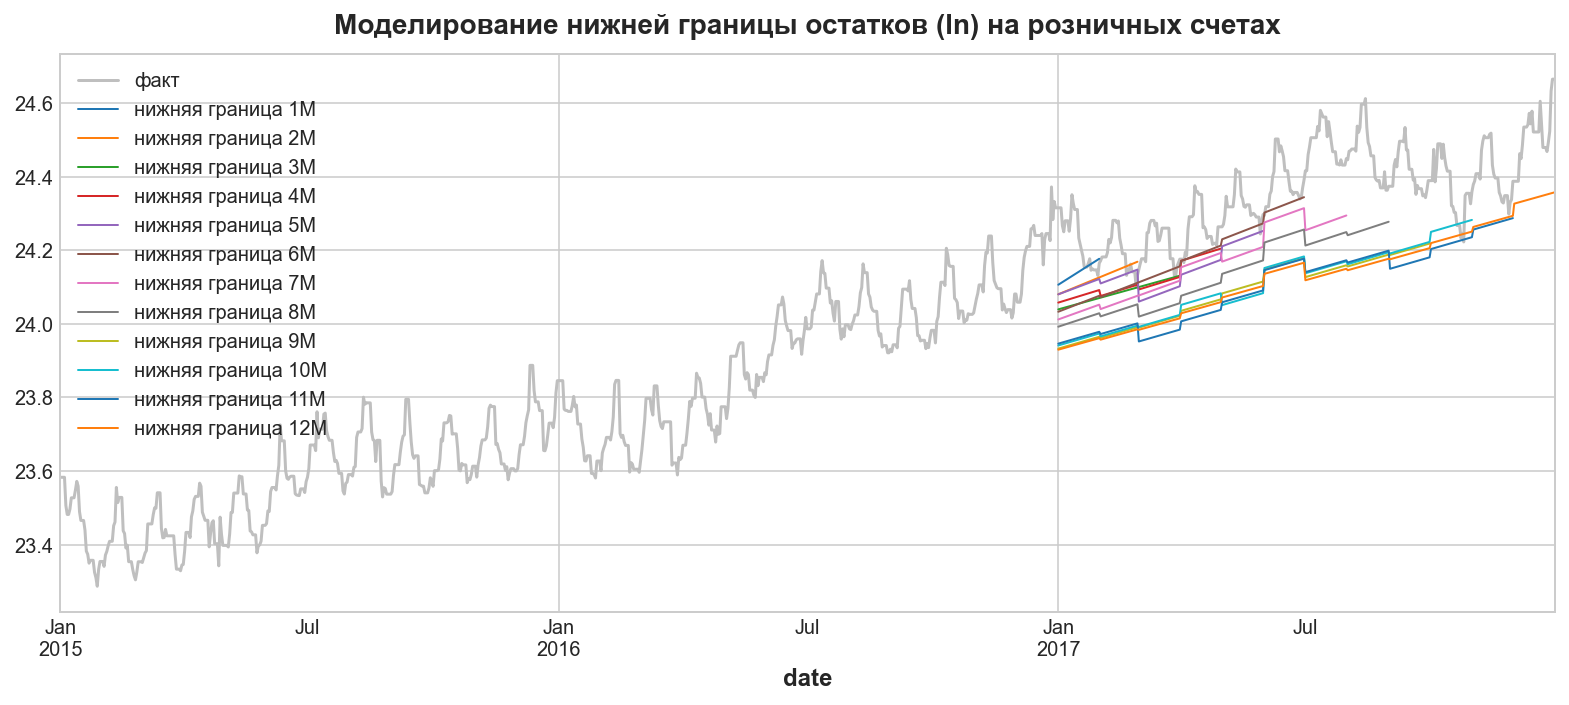

In [338]:
ax = train_test.log_balance.plot(**plot_params, label='факт')
for p in ['1M','2M','3M','4M','5M','6M','7M','8M','9M','10M','11M','12M']:
    _, y_pred,  _ = pr_lib.predict_timeframe('2017-01-01',train_test, period=p)
    ax = y_pred.plot(ax=ax, linewidth=1, label='нижняя граница '+p )
ax.set_title('Моделирование нижней границы остатков (ln) на розничных счетах')
_ = ax.legend();

В целом модель предсказания минимального остатка на текущих счетах подготовлена.  Интересно посмотреть на качество этой модели.
Для оценки качества в соответствии с учловиями задачи рассчитывается одно значение - прогнозируемый минимум остатка средств на счете.  Минимум рассчитывается по всему периоду для величины среднего остатка на счете минус отклонение квантиля 0.01.

### Изучение модельной ошибки

Интересно посмотреть, как меняется ошибка предсказания в зависимости от положения временного окна. Необходимые функции вынесены в библиотеку P10_lib.py.

Необходимо обратить внимание читателя что в качестве прогнозной оценки неснижаемого минимума использована оценка среднего значения минус отклонение квантиля 0.01. Если взять иной уровень квантиля - например 0.05 оценка будет другой.  В качестве величины оценки берется отклонение (превышение) фактического минимального остатка за период от прогнозного значения, деленное на фактическое значение.  Такая оценка ошибки отражает либо превышение фактического остатка над предсказываемым, либо (с минусом) - величину пробития предсказываемого остатка фактическим значением.

In [413]:
pr_lib = reload(pr_lib)
err_vals = {}

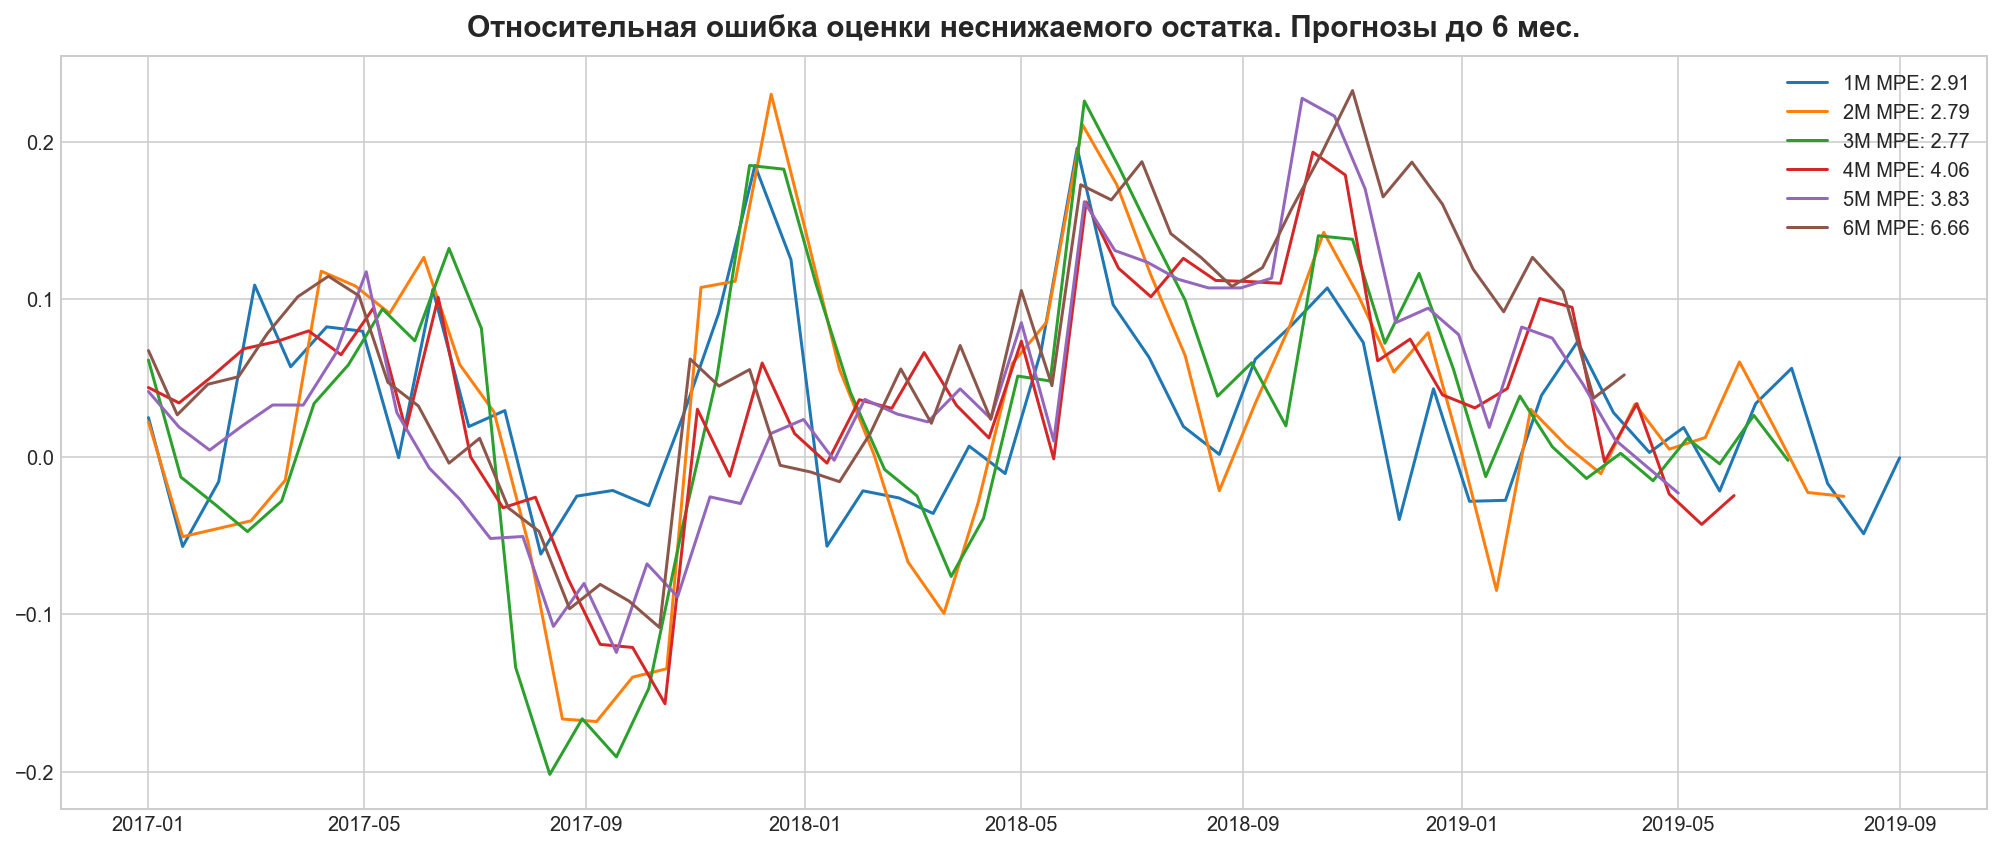

In [420]:
scope = {'1M':'2019-09-01', '2M': '2019-08-01', '3M':'2019-07-01', '4M':'2019-06-01', '5M':'2019-05-01', '6M':'2019-04-01'}

plt.figure(figsize=(14,6))
for pr, dt in scope.items():
    cp = pr_lib.make_check_points('2017-01-01',dt,50)
    cp['err'] = cp.date.apply(lambda d: pr_lib.model_error(str(d.date()), df, pr))
    cp = cp.set_index('date')
    err_vals[pr] = cp.err.mean()*100
    plt.plot(cp.index, cp.err, label=pr+' MPE: {:.2f}'.format(err_vals[pr]))

plt.legend(loc='best')
plt.title('Относительная ошибка оценки неснижаемого остатка. Прогнозы до 6 мес.', fontsize=15)
plt.show();


В среднем оценки неснижаемого остатка для небольших горизонтов прогнозирования недалеко отошли от 0, хотя есть превышение на временном горизонте тестироания.

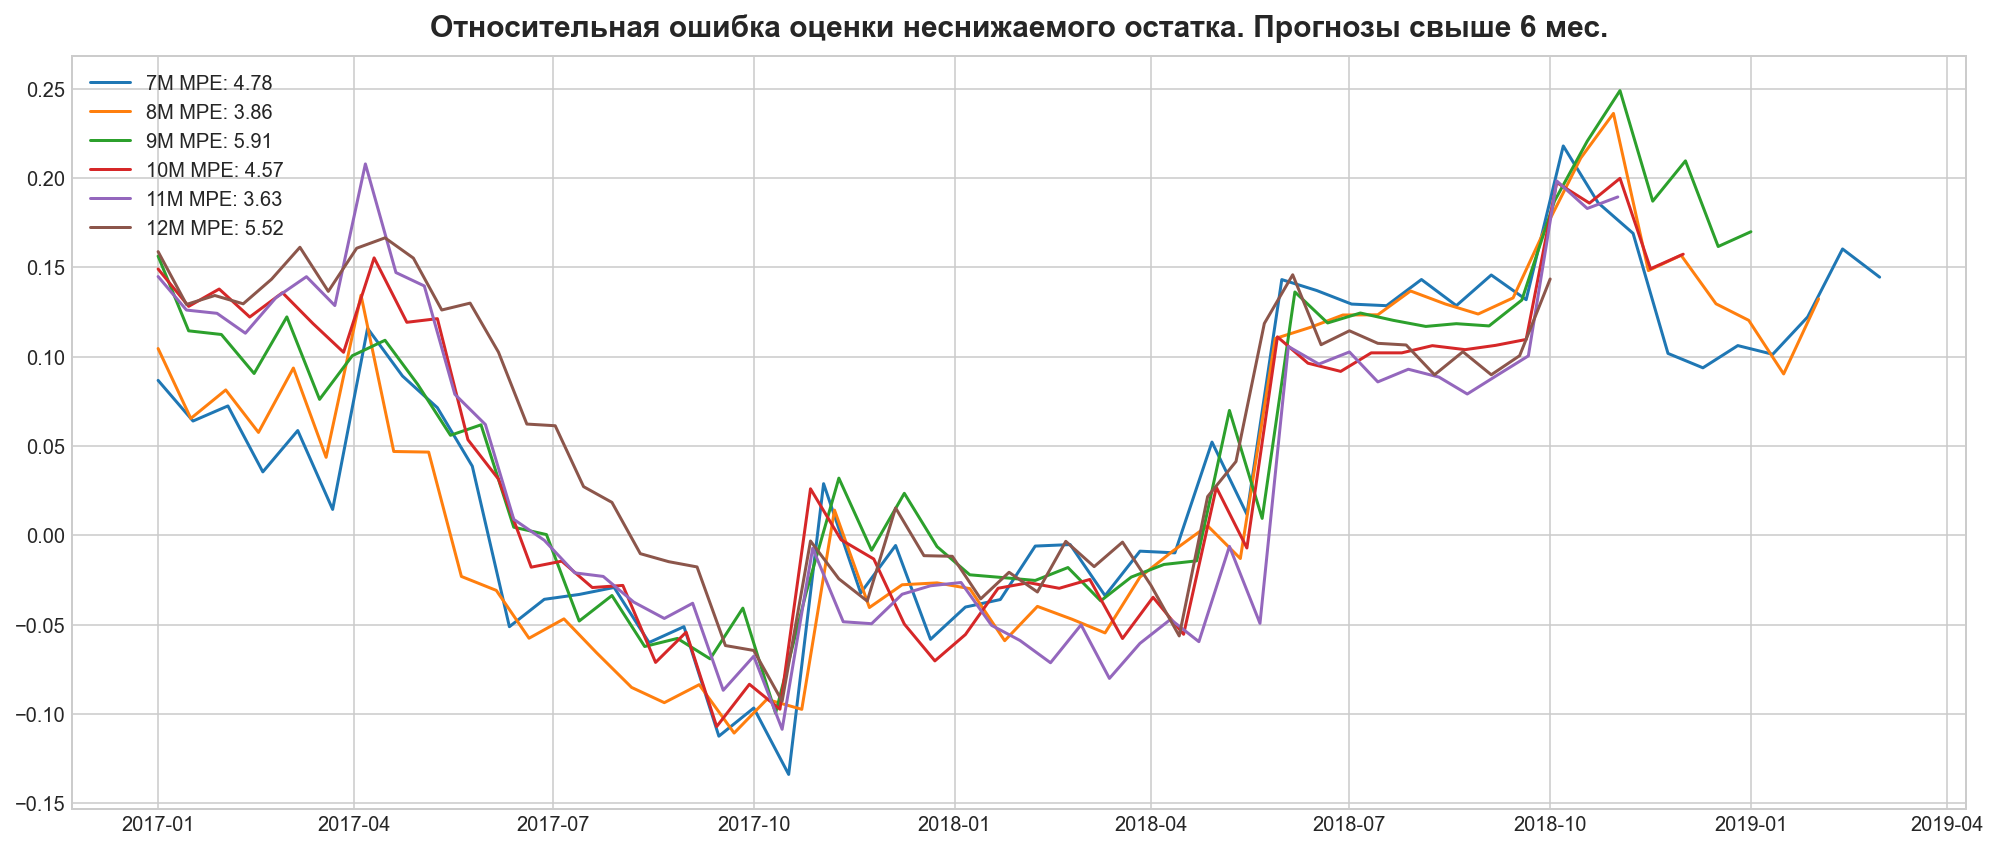

In [419]:
scope = {'7M':'2019-03-01',  '8M':'2019-02-01', '9M':'2019-01-01', '10M':'2018-12-01', '11M':'2018-11-01',  '12M':'2018-10-01'}

plt.figure(figsize=(14,6))
for pr, dt in scope.items():
    cp = pr_lib.make_check_points('2017-01-01',dt,50)
    cp['err'] = cp.date.apply(lambda d: pr_lib.model_error(str(d.date()), df, pr))
    cp = cp.set_index('date')
    err_vals[pr] = cp.err.mean()*100
    plt.plot(cp.index, cp.err, label=pr+' MPE: {:.2f}'.format(err_vals[pr]))

plt.legend(loc='best')
plt.title('Относительная ошибка оценки неснижаемого остатка. Прогнозы свыше 6 мес.', fontsize=15)
plt.show();

В целом - оценки неснижаемых горизонтов планирования от 6 месяцев больше отошли от нуля на временном горизонте тестирования.

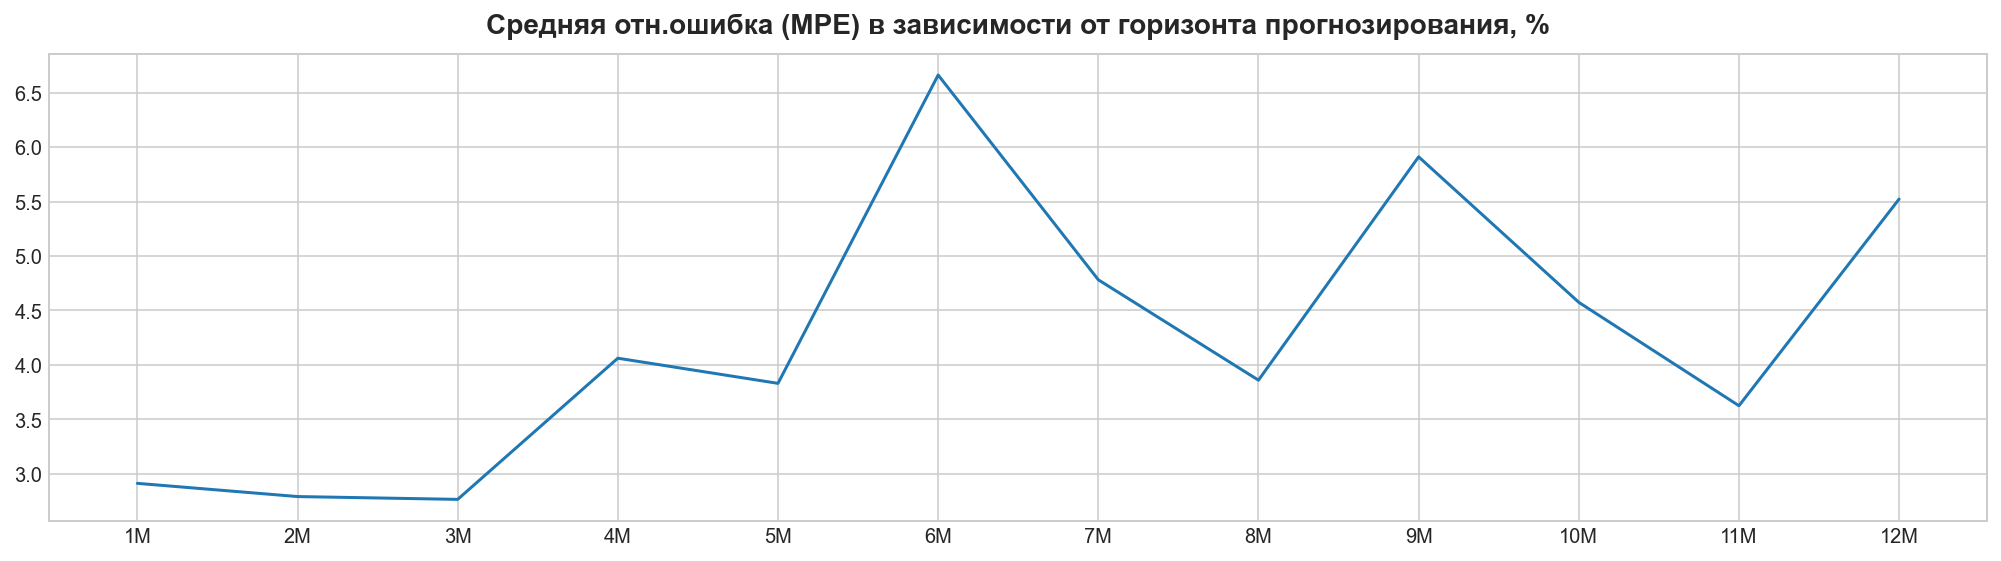

In [418]:
plt.figure(figsize=(14,4))
plt.plot(err_vals.keys(),err_vals.values())
plt.title('Средняя отн.ошибка (MPE) в зависимости от горизонта прогнозирования, %')
plt.show();

В целом в среднем на доступном временном горизонте тестирования модель чаще ошибается в плюс и недооценивает неснижаемую сумму остатков.  При использовании более высокого квантиля, например 0.03 или 0.05 эту разницу можно было бы и нивелировать.

Направления улучшения модели:
- Попробовать перейти от линейного экстраполирования тренда к нелинейному - посмотреть как изменится качество при аппроксимации тренда уравнением 2го или 3го порядка. Модель к этому готова. Возможно, нелинейность будет хорошо работать на длительных горизонтах прогнозирования.
- Попробовать определять сезонный профиль отдельно, на 2х летнем наборе данных, а модель обучать потом уже на меньшем наборе данных.